# Graph Convolutional Network with Numpy

In [1]:
import os
import sys
import time
import argparse
import random
import visdom
import networkx as nx
import numpy as np
from collections import defaultdict
from pyvis.network import Network
import matplotlib.pyplot as plt
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

In [2]:
if not os.path.exists('assets'):
    os.mkdir('assets')

### Hyperparameters

In [3]:
seed = 0
epochs = 10000
lr = 0.001
hidden_dim = 16
hidden_dim2 = 2 # change to 20 to increase performance
np.random.seed(seed)

### Visualizations

In [4]:
def plot_in_visdom(data, title='', xlabel='', ylabel=''):
    vis = visdom.Visdom()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(data)
    vis.matplot(plt)
    
    vis.close()

### Graph data

In [5]:
G = nx.karate_club_graph()

In [6]:
num_nodes, num_edges = G.number_of_nodes(), G.number_of_edges()

### Generate labels from communities

In [7]:
# followed example from reference [2] for generating labels
communities = greedy_modularity_communities(G)
node_labels = np.zeros(G.number_of_nodes())
classes = set()

for i, c in enumerate(communities):
    node_labels[list(c)] = i
    classes.add(i)
    
num_classes = len(classes)
labels = (np.eye(len(classes))[node_labels.astype(int)]).T

classes, samples = labels.shape
print(f'labels.shape: {labels.shape}\t classes: {classes}\t samples: {samples}')

# each element after argmax represents the class and index represents the node.
print(np.argmax(labels, axis=0))

labels.shape: (3, 34)	 classes: 3	 samples: 34
[2 1 1 1 2 2 2 1 0 1 2 2 1 1 0 0 2 1 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


### Color nodes

In [8]:
def random_color():
    return '#%02X%02X%02X' % (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))


def color_graph(G, color_map, node_labels, pos=None, save=False, name=''):
    colored = Network(width='100%', notebook=True)
    node_color = []
    kwargs = {}

    for node in G.nodes():
        if pos:
            kwargs = {'x': pos[node][0], 'y': pos[node][1]}
        colored.add_node(node, color=color_map[int(node_labels[node])], **kwargs)
        node_color.append(color_map[int(node_labels[node])])

    for edge in G.edges():
        colored.add_edge(int(edge[0]), int(edge[1]))
        
    if save and name:
        colored.save_graph(f'{name}.html')
        colored.show(f'{name}.html')
        
    return colored, node_color


def draw_encoding(G, pos, node_color, width=10, height=10, name=''):
    fig, ax = plt.subplots(figsize=(width, height))
    
    nx.draw(
        G, 
        pos, 
        with_labels=False, 
        node_color=node_color, 
        ax=ax,
        edge_color='gray')
    
    plt.savefig(f'{name}.png', bbox_inches='tight', transparent=True)


# uncomment for random colors
# color_map = {cls: random_color() for cls in classes}
color_map = {0: '#46FB47', 1: '#B9E6B5', 2: '#9F9EBF'}

graph, node_color = color_graph(G, color_map, node_labels)
graph.show('colored_graph.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


#### Renormalization trick

$A$ is the adjacency matrix, $I$ is the identity matrix, and $N$ is the cardinality of the set of nodes in the graph.

$$
\begin{align}
    \tilde{A} &= A + I_{N}\\
       \tilde{\mathcal{D}}_{ii} &= \sum_{i}\tilde{A}_{ij}\\
    \hat{\mathcal{A}}&=\tilde{\mathcal{D}}^{-\frac{1}{2}}\tilde{\mathcal{A}}\tilde{\mathcal{D}}^{-\frac{1}{2}}
\end{align}
$$

In this notebook, each column of the design matrix `A_hat` corresponds to a single node and each row is a feature dimension.

In [9]:
def renormalization(G):
    A = np.asarray(nx.to_numpy_matrix(G))
    I = np.eye(len(A))
    A_tilde = A + I
    D_tilde = np.zeros(A.shape, int)
    np.fill_diagonal(D_tilde, np.sum(A_tilde, axis=1).flatten())
    D_tilde = np.linalg.inv(D_tilde)
    D_tilde = np.power(D_tilde, 0.5)
    return D_tilde @ A_tilde @ D_tilde

In [10]:
nx.to_numpy_matrix(G)

matrix([[0., 4., 5., ..., 2., 0., 0.],
        [4., 0., 6., ..., 0., 0., 0.],
        [5., 6., 0., ..., 0., 2., 0.],
        ...,
        [2., 0., 0., ..., 0., 4., 4.],
        [0., 0., 2., ..., 4., 0., 5.],
        [0., 0., 0., ..., 4., 5., 0.]])

In [11]:
# Must pre-process offline
A_hat = renormalization(G)
print(A_hat)
print(A_hat.shape)

[[0.02325581 0.11136921 0.13076645 ... 0.06502561 0.         0.        ]
 [0.11136921 0.03333333 0.18786729 ... 0.         0.         0.        ]
 [0.13076645 0.18786729 0.02941176 ... 0.         0.0549235  0.        ]
 ...
 [0.06502561 0.         0.         ... 0.04545455 0.13655775 0.12182898]
 [0.         0.         0.0549235  ... 0.13655775 0.02564103 0.11437725]
 [0.         0.         0.         ... 0.12182898 0.11437725 0.02040816]]
(34, 34)


### Train-Test Split

In [12]:
train_split = 1
test_split = 1 - train_split
train_nodes = random.sample(list(range(34)), int(train_split * num_nodes))
test_nodes = list(set(range(34)) - set(train_nodes))

train_nodes.sort()
test_nodes.sort()
print(f'train_nodes ({len(train_nodes)}): {train_nodes}')
print(f'test_nodes  ({len(test_nodes)}): {test_nodes}')

train_nodes (34): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
test_nodes  (0): []


### Train-Test Masks Features

Only creating masks for features. Do not need for labels because the model outputs (3,34), so basically it's predicting for every node every forward pass.

In [13]:
train_mask = np.zeros((num_nodes, num_nodes))
train_mask[train_nodes, :] = np.ones(num_nodes)
train_mask.T[train_nodes, :] = np.ones(num_nodes)
test_mask = np.logical_not(train_mask).astype(int)

assert (train_mask + test_mask == np.ones((num_nodes, num_nodes))).all()

### Helper functions

In [14]:
def init(model, scheme):
    for i, layer in enumerate(model.parameters):
        model.parameters[i].W = scheme(*layer.W.shape)
        model.parameters[i].b = scheme(*layer.b.shape)
        
    return model


def glorot_init(in_dim, out_dim):
    sd = np.sqrt(6.0 / (in_dim + out_dim))
    return np.random.uniform(-sd, sd, size=(in_dim, out_dim))

### Optimizer

In [15]:
class GradientDescent(object):
    def __init__(self, parameters, learning_rate):
        self.parameters = parameters
        self.learning_rate = learning_rate
        
        
    def zero_gradients(self):
        for layer in self.parameters:
            
            layer.dW = np.zeros(layer.W.shape)
            
            if hasattr(layer, 'b'):
                layer.db = np.zeros(layer.b.shape)
    
    
    def step(self):
        for i, layer in enumerate(self.parameters):
            
            layer.W -= self.learning_rate * layer.dW
            
            if hasattr(layer, 'db'):
                layer.b -= self.learning_rate * layer.db

### Activation functions

In [16]:
def relu(x):
    return np.maximum(0, x)

def relu_(x):
    return (x > 0).astype(int)

def softmax(x, axis=0):
    return np.exp(x)/np.sum(np.exp(x), axis=axis, keepdims=True)

### Embedding Layer

In [17]:
class Embedding(object):
    def __init__(self, embedding_dim, num_embeddings):
        self.W = np.eye(embedding_dim, num_embeddings)
        self.dW = np.zeros((embedding_dim, num_embeddings))
        self.indices = None
        
    def __call__(self, indices, embed=False):
        self.indices = indices
        return self.W[:, indices]
    
    def backward(self, error):
        np.add.at(self.dW.T, self.indices, error)

Each column is an embedding vector and therefore matrices in this code assume features are also column vectors.

$$
\mathcal{E}^{34\times 34}=\begin{bmatrix}
    \vert & \ldots & \vert \\
    e_{i, 1} & \ldots & e_{i,34}\\
    \vert & \ldots & \vert
\end{bmatrix}
$$

### Graph Convolutional Layer

$$
\text{ReLU}(\hat{A}XW^{1}+b^{1})
$$

In [18]:
class GCLayer(object):
    def __init__(self, input_dim, output_dim, name=''):
        self.name = name
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.W = glorot_init(output_dim, input_dim)
        self.dW = np.zeros(self.W.shape)
        self.b = np.ones((output_dim, 1))
        self.db = np.zeros(self.b.shape)

        
    '''
    inputs:
    G (nx.Graph)   Normalized Laplacian matrix for a static graph.
                   Dimensions: N x N where N is the number of nodes.
    x (np.ndarray) Embedding matrix
                   Dimensions: N x F where F is the number of features.
    '''
    def __call__(self, G, x, activation=None):
        if not activation:
            activation = lambda x: x
            
        self.z = x
        self.a = activation(x.T).T
        
        # this is purely stylistic preference 
        # so can right-multiply features with weights
        X = (G @ self.a).T
        
        # transpose so can multiply by adjacency matrix in next layer, (n,h)
        return (self.W @ X + self.b).T
    
    
    def backward(self, G, error, derivative=None):
        if not derivative:
            derivative = lambda x: x
            
        self.dW = error @ self.a
        self.db = np.sum(error, axis=1, keepdims=True)
        
        return self.W.T @ error * (G @ derivative(self.z)).T

    

### Linear Layer

In [19]:
class Linear(object):
    def __init__(self, input_dim, output_dim, name=''):
        self.name = name
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.W = glorot_init(output_dim, input_dim)
        self.dW = np.zeros(self.W.shape)
        self.b = np.ones((self.output_dim, 1))
        self.db = np.zeros(self.b.shape)    

    '''
    inputs:
    x (np.ndarray) Inputs to this layer
    
    outputs:
    a (np.ndarray) Output activations
    '''
    def __call__(self, x, activation=None):
        if not activation:
            activation = lambda x: x
            
        self.z = x
        self.a = activation(x)
        
        return self.W @ self.a + self.b
    
    
    '''
    inputs:
    error (np.ndarray) Error signal of shape (W.out_dim, batch_size) from subsequent layer
    
    outputs:
    
    '''
    def backward(self, error, derivative=None):
        if not derivative:
            derivative = lambda x: x
            
        batch_size = error.shape[1]

        self.dW = error @ self.a.T
        self.db = np.sum(error, axis=1, keepdims=True)
        
        return self.W.T @ error * derivative(self.z)
        

### Graph Convolutional Network

In [20]:
class GCN(object):
    def __init__(self, graph, num_classes):
        self.G = graph
        self.nodes = self.G.shape[0]
        self.embedding = Embedding(self.nodes, self.nodes)
        self.l0 = GCLayer(self.nodes, hidden_dim, name='l0')
        self.l1 = GCLayer(hidden_dim, hidden_dim2, name='l1')
        self.l2 = Linear(hidden_dim2, num_classes, name='l2')
        self.parameters = [self.embedding, self.l0, self.l1, self.l2]
        
    '''
    inputs:
    mask (list) Node ids corresponding to columns in embedding matrix
    '''
    def __call__(self, mask, encode=False, embed=False):
        e = self.embedding(mask, embed=embed)
        a0 = self.l0(self.G, e, activation=None)
        a1 = self.l1(self.G, a0, activation=relu).T
        
        if encode:
            return a1
        
        a2 = self.l2(a1, relu)
        
        return softmax(a2)
    
    
    def backward(self, x):
        d2 = self.l2.backward(x, derivative=relu_)
        d1 = self.l1.backward(self.G, d2, derivative=relu_)
        d0 = self.l0.backward(self.G, d1, derivative=None)
        self.embedding.backward(d0)
        

### Forward pass

#### Design/ Input matrix

- This is not the embedding matrix. This is the feature matrix. Each column represents one node and is initialized to the design matrix for mathematical convenience. It can be interpreted as assigning each node a unique id as a one-hot vector similar to how word vectors were originally represented.
- This matrix does not change throughout training.

$$
\begin{align}
    \mathcal{X}=
    \underset{\mathcal{X}\in\mathbb{R}^{34\times34}}{
    \begin{bmatrix}
        \vert & \ldots & \vert \\
        x_{i, 1} & \ldots & x_{i,34}\\
        \vert & \ldots & \vert
    \end{bmatrix}}
\end{align}
$$

#### Embedding layer

- Denoted here as $\mathcal{A}^{(1)}$ for consistency with the mathematical notation for backpropagation and to match the code.
- This layer is initialized to a zero matrix, but is not used in the forward pass during training.
- Only updated during the backwards and used in the forward pass during inference.

$$
\begin{align}
    \mathcal{A}^{(1)}=
    \underset{\mathcal{E}\in\mathbb{R}^{34\times34}}{
    \begin{bmatrix}
        \vert & \ldots & \vert \\
        e_{i, 1} & \ldots & e_{i,34}\\
        \vert & \ldots & \vert
    \end{bmatrix}}
\end{align}
$$

#### Layer 1 - Graph Convolution

- The bias vector $\mathbb{R}^{16\times 1}$ is broadcasted during addition as $\mathbb{R}^{16\times 34}$.
- I do not apply ReLU to the entire output of the layer at the end because the subsequent layer needs the preactivations (values before applying the non-linearity) of the current layer to compute its error signal to pass back during backpropagation. Instead, I apply ReLU at the beginning of the subsequent layer so later it can be used to calculate the derivative to update that layer's weights. Aesthetically and notationally this is not as elegant, but it's cleaner and simpler to implement. However, this is not an efficient implementation because of the excessive number of transpose operations.


$$
\begin{align}
    \mathcal{A}^{(2)}=
    \Bigg(
        \underset{\mathcal{W}^{(1)}\ \in\ \mathbb{R}^{16\times34}}{
        \begin{bmatrix}
            w_{1,1} & \ldots & w_{1,34}\\
            \vdots & \ddots & \vdots\\
            w_{16,1} & \ldots & w_{16,34}
        \end{bmatrix}}
        \Biggl(
        \
            \underset{\hat{\mathcal{A}}\ \in\ \mathbb{R}^{34\times34}}{
            \begin{bmatrix}
                \alpha_{1,1} & \ldots & \alpha_{1,34}\\
                \vdots & \ddots & \vdots\\
                \alpha_{34,1} & \ldots & \alpha_{34,34}
            \end{bmatrix}}
            \ 
            \underset{\mathcal{X}\ \in\ \mathbb{R}^{34\times34}}{
            \begin{bmatrix}
                e_{1,1} & \ldots & e_{1,34}\\
                \vdots & \ddots & \vdots\\
                e_{34,1} & \ldots & e_{34,34}
            \end{bmatrix}}
        \
        \Biggl)^{\top}
        +
        \underset{\mathcal{b}^{(1)}\ \in\ \mathbb{R}^{16\times34}}{
        \begin{bmatrix}
            b_{1,1} & \ldots & b_{1,34}\\
            \vdots & \ddots & \vdots\\
            b_{16,1} & \ldots & b_{16,34}
        \end{bmatrix}}
    \Bigg)^{\top}
\end{align}
$$

#### Layer 2 - Graph Convolution

- The preactivations are transposed because I represent the input matrix to each layer a column-wise features, so I can do right-hand matrix multiplication with the weight matrix e.g. generally $\mathcal{WX}$, where $\mathcal{X}=\hat{\mathcal{A}}\mathcal{X}^{'}$ (normalized adjacency matrix dotted with the activation matrix).

$$
\begin{align}
    \mathcal{A}^{(3)}=
    &\Biggl(
    \
        \underset{\mathcal{W}^{(2)}\ \in\ \mathbb{R}^{2\times16}}{
        \begin{bmatrix}
            w_{1,1} & \ldots & w_{1,16}\\
            w_{2,1} & \ldots & w_{2,16}
        \end{bmatrix}}
        \
        \Biggl(
        \
            \underset{\hat{\mathcal{A}}\ \in\ \mathbb{R}^{34\times34}}{
            \begin{bmatrix}
                \alpha_{1,1} & \ldots & \alpha_{1,34}\\
                \vdots & \ddots & \vdots\\
                \alpha_{34,1} & \ldots & \alpha_{34,34}
            \end{bmatrix}}
            \
            \text{ReLU}
            \Biggl(
            \underset{\mathcal{A}^{(2)}\ \in\ \mathbb{R}^{34\times16}}{
            \begin{bmatrix}
                a_{1,1} & \ldots & a_{1,16}\\
                \vdots & \ddots & \vdots\\
                a_{34,1} & \ldots & a_{34,16}
            \end{bmatrix}}^{\top}
            \Biggl)^{\top}
        \
        \Biggl)^{\top}
        +
        \underset{\mathcal{b}^{(2)}\ \in\ \mathbb{R}^{2\times34}}{
        \begin{bmatrix}
            b_{1,1} & \ldots & b_{1,34}\\
            b_{2,1} & \ldots & b_{2,34}
        \end{bmatrix}}
    \
    \Biggr)^{\top}\\
\end{align}
$$


#### Layer 3 - Linear
$$
\begin{align}
    \mathcal{A}^{(4)}&=
    \text{Softmax}
    \Biggl(
    \
        \underset{\mathcal{W}^{(3)}\ \in\ \mathbb{R}^{3\times2}}{
        \begin{bmatrix}
            w_{1,1} & w_{1,2}\\
            w_{2,1} & w_{2,2}\\
            w_{3,1} & w_{3,2}
        \end{bmatrix}}
        \
        \Biggl(
        \
            \underset{\hat{\mathcal{A}}\ \in\ \mathbb{R}^{34\times34}}{
            \begin{bmatrix}
                \alpha_{1,1} & \ldots & \alpha_{1,34}\\
                \vdots & \ddots & \vdots\\
                \alpha_{34,1} & \ldots & \alpha_{34,34}
            \end{bmatrix}}
            \
            \text{ReLU}
            \Bigg(
            \underset{\mathcal{A}^{(3)}\ \in\ \mathbb{R}^{34\times2}}{
            \begin{bmatrix}
                a_{1,1} & a_{1,2}\\
                \vdots & \vdots\\
                a_{34,1} & a_{34,2}
            \end{bmatrix}}
            \Bigg)
        \Biggl)^{\top}
        +
        \underset{\mathcal{b}^{(3)}\ \in\ \mathbb{R}^{3\times34}}{
        \begin{bmatrix}
            b_{1,1} & \ldots & b_{1,34}\\
            b_{2,1} & \ldots & b_{2,34}\\
            b_{3,1} & \ldots & b_{3,34}
        \end{bmatrix}}
    \
    \Biggr)\\
    &=\
    \text{Softmax}
    \Biggl(
    \
        \underset{\mathcal{Z}^{(3)}\ \in\ \mathbb{R}^{3\times34}}{
        \begin{bmatrix}
            z_{1,1} & \ldots & z_{1,34}\\
            z_{2,1} & \ldots & z_{2,34}\\
            z_{3,1} & \ldots & z_{3,34}
        \end{bmatrix}}
    \
    \Biggr)\\
    &=
    \quad\quad\quad\quad\underset{\mathcal{A}^{(4)}\ \in\ \mathbb{R}^{3\times34}}{
    \begin{bmatrix}
        a_{1,1} & \ldots & a_{1,34}\\
        a_{2,1} & \ldots & a_{2,34}\\
        a_{3,1} & \ldots & a_{3,34}
    \end{bmatrix}}
\end{align}
$$


### Loss function

Why we use cross entropy loss for classification when doing MLE:
https://en.wikipedia.org/wiki/Cross_entropy#Relation_to_maximum_likelihood

In [21]:
def cross_ent(predictions, targets):
    N = predictions.shape[1] # (3,34), so index 1 for samples
    t = np.squeeze(np.asarray(targets))
    p = np.squeeze(np.asarray(predictions))
    return -np.sum(t*np.log(p))/N

def cross_ent_(output, labels):
    return output - labels

### Backpropagation

#### Cross entropy loss

$$
\begin{align}
    \mathcal{L}(\mathcal{X}, \mathcal{H}) =& -\sum_{x,y\in\mathcal{X}} y\cdot \text{log}\ \mathcal{H}_{\mathcal{W},\mathcal{b}}(x)\\
    \delta^{(4)}=&\quad\frac{\partial}{\partial z^{(3)}}\ \mathcal{L}(\mathcal{X}, \mathcal{H})\\
    =&\quad\mathcal{A}^{(4)}-Y\\
    =&\underset{\mathcal{A}^{(4)}\ \in\ \mathbb{R}^{3\times34}}{
    \begin{bmatrix}
        a_{1,1} & \ldots & a_{1,34}\\
        a_{2,1} & \ldots & a_{2,34}\\
        a_{3,1} & \ldots & a_{3,34}
    \end{bmatrix}}
    -
    \underset{\mathcal{Y}^{(4)}\ \in\ \mathbb{R}^{3\times34}}{
    \begin{bmatrix}
        y_{1,1} & \ldots & y_{1,34}\\
        y_{2,1} & \ldots & y_{2,34}\\
        y_{3,1} & \ldots & y_{3,34}
    \end{bmatrix}}\\
    =&\underset{\mathcal{\delta}^{(4)}\ \in\ \mathbb{R}^{3\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        d_{2,1} & \ldots & d_{2,34}\\
        d_{3,1} & \ldots & d_{3,34}
    \end{bmatrix}}
\end{align}
$$

#### Layer 3 - Linear
$$
\begin{align}
    \nabla W^{(3)} =& \delta^{(4)}A^{(3)^{\top}}\\
    =& 
    \underset{\mathcal{\delta}^{(4)}\ \in\ \mathbb{R}^{3\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        d_{2,1} & \ldots & d_{2,34}\\
        d_{3,1} & \ldots & d_{3,34}
    \end{bmatrix}}
    \
    \underset{\mathcal{A}^{(3)^{\top}}\ \in\ \mathbb{R}^{34\times2}}{
    \begin{bmatrix}
        a_{1,1} & a_{1,2}\\
        \vdots & \vdots\\
        a_{34,1} & a_{34,2}
    \end{bmatrix}}\\
    =&
    \underset{\nabla\mathcal{W}^{(3)}\ \in\ \mathbb{R}^{3\times16}}{
    \begin{bmatrix}
        w_{1,1} & \ldots & w_{1,16}\\
        w_{2,1} & \ldots & w_{2,16}\\
        w_{3,1} & \ldots & w_{3,16}
    \end{bmatrix}}\\
    \nabla b^{(3)}=&\sum_{i,j}\delta^{(4)}_{j}\\
    =&\underset{\mathcal{\delta}^{(4)}\ \in\ \mathbb{R}^{3\times1}}{
    \begin{bmatrix}
        d_{1}\\
        d_{2}\\
        d_{3}
    \end{bmatrix}}\\
    \delta^{(3)} =&\mathcal{W}^{(3)^{\top}}\delta^{(4)}\odot\frac{\partial}{\partial z^{(2)}}\text{ReLU}(z^{(2)})\\
    =&
    \underset{\mathcal{W}^{(3)^{\top}}\ \in\ \mathbb{R}^{16\times3}}{
    \begin{bmatrix}
        w_{1,1} & w_{1,2} & w_{1,3}\\
        \vdots & \ddots & \vdots\\
        w_{16,1} & w_{16,2} & w_{16,3}
    \end{bmatrix}}
    \
    \underset{\mathcal{\delta}^{(4)}\ \in\ \mathbb{R}^{3\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        d_{2,1} & \ldots & d_{2,34}\\
        d_{3,1} & \ldots & d_{3,34}
    \end{bmatrix}}
    \odot
    \frac{\partial}{\partial z^{(2)}}
    \text{ReLU}
    \Biggl(
    \ 
        \underset{\mathcal{Z}^{(2)}\ \in\ \mathbb{R}^{16\times34}}{
        \begin{bmatrix}
            z_{1,1} & \ldots & z_{1,34}\\
            \vdots & \ddots & \vdots\\
            z_{16,1} & \ldots & z_{16,34}
        \end{bmatrix}}
    \ \Biggl)\\
    =&
    \underset{\mathcal{\delta}^{(3)}\ \in\ \mathbb{R}^{16\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        \vdots & \ddots & \vdots\\
        d_{16,1} & \ldots & d_{16,34}
    \end{bmatrix}}
\end{align}
$$

#### Layer 2 - Graph Convolution
$$
\begin{align}
    \nabla W^{(2)} =& \delta^{(3)}A^{(2)^{\top}}\\
    =&
    \underset{\mathcal{\delta}^{(3)}\ \in\ \mathbb{R}^{16\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        \vdots & \ddots & \vdots\\
        d_{16,1} & \ldots & d_{16,34}
    \end{bmatrix}}
    \
    \underset{\mathcal{A}^{(2)^{{\top}}}\ \in\ \mathbb{R}^{34\times16}}{
            \begin{bmatrix}
                a_{1,1} & \ldots & a_{1,16}\\
                \vdots & \ddots & \vdots\\
                a_{34,1} & \ldots & a_{34,16}
            \end{bmatrix}}\\
    \nabla b^{(2)} =& \delta^{(3)}\\
    =&
    \underset{\mathcal{\delta}^{(3)}\ \in\ \mathbb{R}^{16\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        \vdots & \ddots & \vdots\\
        d_{16,1} & \ldots & d_{16,34}
    \end{bmatrix}}\\
    \delta^{(2)} =&\mathcal{W}^{(2)^{\top}}\delta^{(3)}\odot\frac{\partial}{\partial z^{(1)}}\text{ReLU}(z^{(1)})\\
    =&
    \underset{\mathcal{W}^{(2)^{\top}}\ \in\ \mathbb{R}^{16\times16}}{
    \begin{bmatrix}
        w_{1,1} & \ldots & w_{1,16}\\
        \vdots & \ddots & \vdots\\
        w_{16,1} & \ldots & w_{16,16}
    \end{bmatrix}}
    \
    \underset{\mathcal{\delta}^{(3)}\ \in\ \mathbb{R}^{16\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        \vdots & \ddots & \vdots\\
        d_{16,1} & \ldots & d_{16,34}
    \end{bmatrix}}
    \
    \odot\frac{\partial}{\partial z^{(1)}}\text{ReLU}
    \Biggl(
    \
        \underset{\mathcal{Z}^{(1)}\ \in\ \mathbb{R}^{16\times34}}{
        \begin{bmatrix}
            z_{1,1} & \ldots & z_{1,34}\\
            \vdots & \ddots & \vdots\\
            z_{16,1} & \ldots & z_{16,34}
        \end{bmatrix}}
    \
    \Biggl)\\
    =&
    \underset{\mathcal{\delta}^{(2)}\ \in\ \mathbb{R}^{16\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        \vdots & \ddots & \vdots\\
        d_{16,1} & \ldots & d_{16,34}
    \end{bmatrix}}
\end{align}
$$

#### Layer 1 - Graph Convolution
$$
\begin{align}
    \nabla W^{(1)} =& \delta^{(2)}\mathcal{X}^{\top}\\
    =&
    \underset{\mathcal{\delta}^{(2)}\ \in\ \mathbb{R}^{16\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        \vdots & \ddots & \vdots\\
        d_{16,1} & \ldots & d_{16,34}
    \end{bmatrix}}
    \ 
    \underset{\mathcal{X^{\top}}\ \in\ \mathbb{R}^{34\times34}}{
            \begin{bmatrix}
                x_{1,1} & \ldots & x_{1,34}\\
                \vdots & \ddots & \vdots\\
                x_{34,1} & \ldots & x_{34,34}
            \end{bmatrix}}\\
    \nabla b^{(1)} =& \delta^{(2)}\\
    =& \underset{\mathcal{\delta}^{(2)}\ \in\ \mathbb{R}^{16\times34}}{
    \begin{bmatrix}
        d_{1,1} & \ldots & d_{1,34}\\
        \vdots & \ddots & \vdots\\
        d_{16,1} & \ldots & d_{16,34}
    \end{bmatrix}}
\end{align}
$$

#### Embedding layer

$$
\begin{align}
    \mathcal{A}^{(1)}=
    \underset{\mathcal{E}\in\mathbb{R}^{34\times34}}{
    \begin{bmatrix}
        \vert & \ldots & \vert \\
        e_{i, 1} & \ldots & e_{i,34}\\
        \vert & \ldots & \vert
    \end{bmatrix}}
\end{align}
$$


### Training loop

In [22]:
def train(model, loss, loss_, epochs, features, labels, test_graph, opt):
    losses, accuracy, encoding = [], [], {}
    
    for e in range(epochs):
        # output: (3, 34)
        output = model(features)
        loss_val = loss(output, labels)
        deriv_loss = loss_(output, labels)
        
        model.backward(deriv_loss)
        opt.step()
        opt.zero_gradients()
        
        if e % 100 == 0:
            # use train_graph for debugging
            acc = np.sum(np.argmax(model(features), axis=0) == np.argmax(labels, axis=0)) / num_nodes
            losses.append(loss_val)
            accuracy.append(acc)
            
        if e % 5000 == 0:
            rep = model(features, encode=True)
            coord = {i: rep[:,i] for i in range(rep.shape[1])}
            encoding[e] = coord

    return losses, accuracy, encoding

In [23]:
train_graph = train_mask * A_hat
test_graph = test_mask * A_hat
model = GCN(train_graph, num_classes)
opt = GradientDescent(model.parameters, lr)
indices = [i for i in range(num_nodes)]
losses, accuracy, encoding = train(model, cross_ent, cross_ent_, epochs, indices, labels, test_graph, opt)

Setting up a new session...


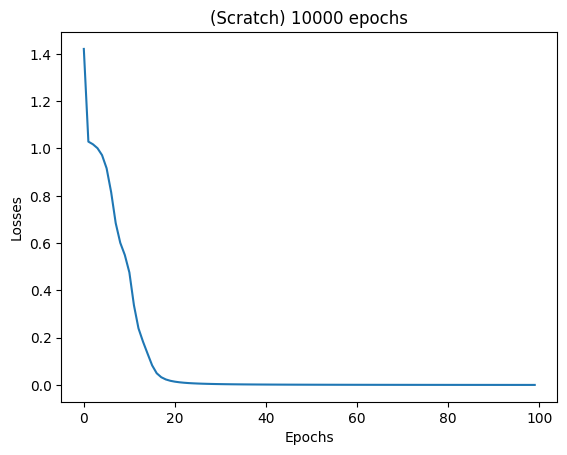

In [24]:
plot_in_visdom(losses, title=f'(Scratch) {epochs} epochs', xlabel='Epochs', ylabel='Losses')

Setting up a new session...


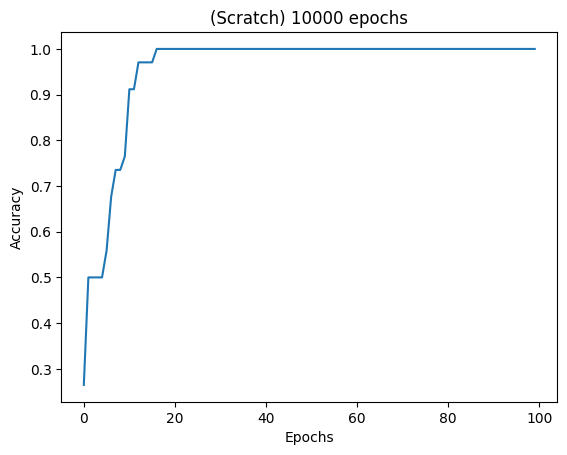

In [25]:
plot_in_visdom(accuracy, title=f'(Scratch) {epochs} epochs', xlabel='Epochs', ylabel='Accuracy')

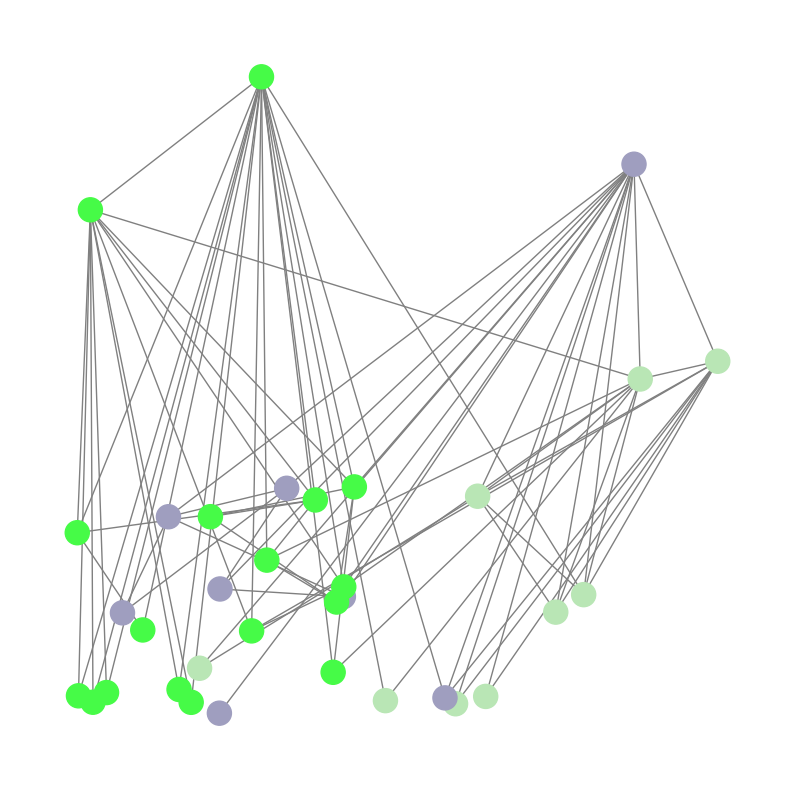

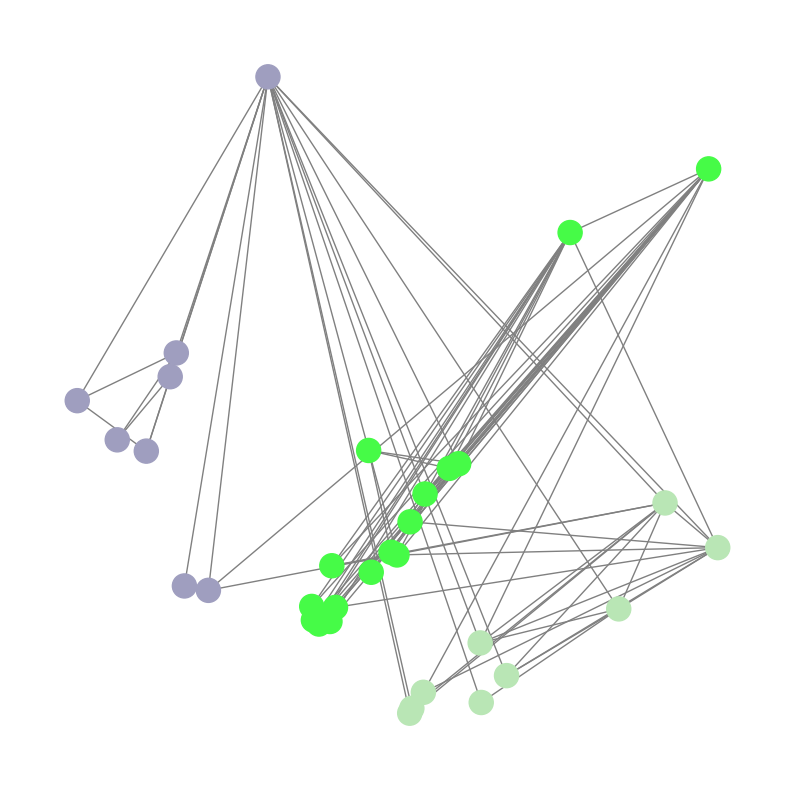

In [26]:
for epoch, rep in encoding.items():
    draw_encoding(G, rep, node_color, name=f'epoch {epoch}')

### Learned Embedding Matrix

In [27]:
learned_embedding = model.embedding.W

In [28]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(learned_embedding)
print(reduced)
print(reduced.shape)

[[ 1.24163641 -0.6436999 ]
 [-0.67962392  0.09108954]
 [-0.29262568 -0.12041579]
 [-0.20509284 -0.09318726]
 [-0.02316914 -0.11313688]
 [-0.10026891 -0.08246825]
 [-0.07744525 -0.1004355 ]
 [-0.19386694 -0.06971609]
 [ 0.27218724  0.06306664]
 [-0.24739999 -0.19172621]
 [-0.09363003 -0.08540806]
 [ 0.17496118 -0.11733757]
 [-0.140672   -0.09105566]
 [-0.4573989  -0.06258452]
 [-0.10655696 -0.0808607 ]
 [-0.11952976 -0.08491296]
 [-0.10379141 -0.08235588]
 [-0.66633312  2.67142156]
 [-0.10567637 -0.0806113 ]
 [ 4.00092163  0.53130985]
 [-0.10276639 -0.08072035]
 [-0.79406327 -0.25374088]
 [-0.11134358 -0.08207713]
 [-0.10393811 -0.08088322]
 [-0.1025059  -0.08225537]
 [-0.10176401 -0.08170379]
 [-0.09994357 -0.07943327]
 [-0.08650102 -0.07667856]
 [-0.07923246 -0.07508069]
 [-0.10353804 -0.08061728]
 [-0.1374561  -0.05180497]
 [-0.08577994 -0.06507829]
 [-0.10805498 -0.08266759]
 [-0.05973785 -0.08423368]]
(34, 2)


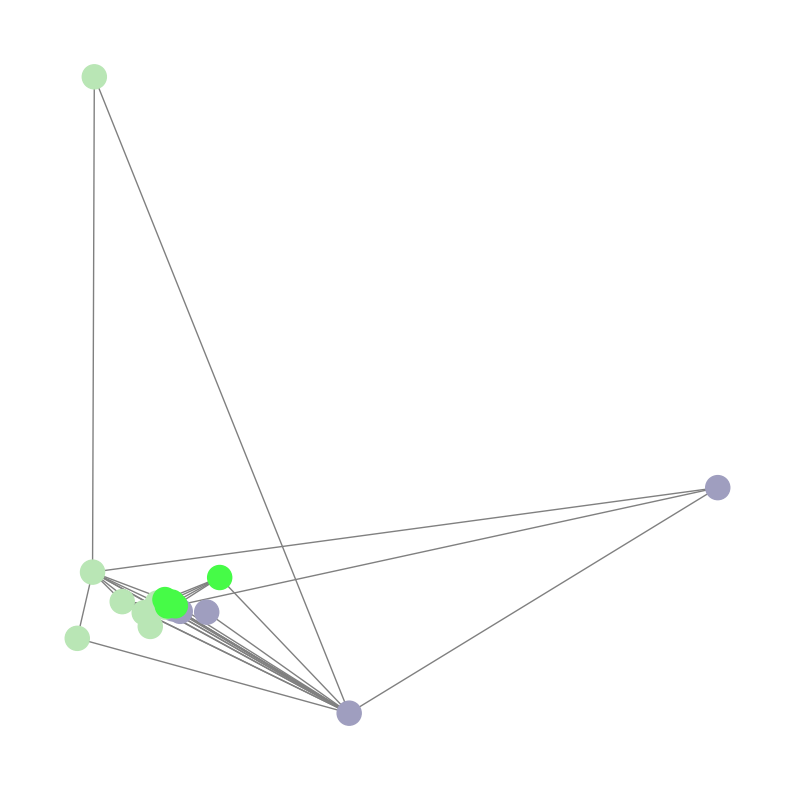

In [29]:
draw_encoding(G, reduced, node_color, name=f'epoch {epoch}')

### Experiment: Resetting embedding matrix

To convince you that the embedding actually contained learned representations
1. Run the embedding throught the encoder and visualize. The nodes should be linearly separated.
2. Set the embedding matrix to zeros and run again with embed=True.

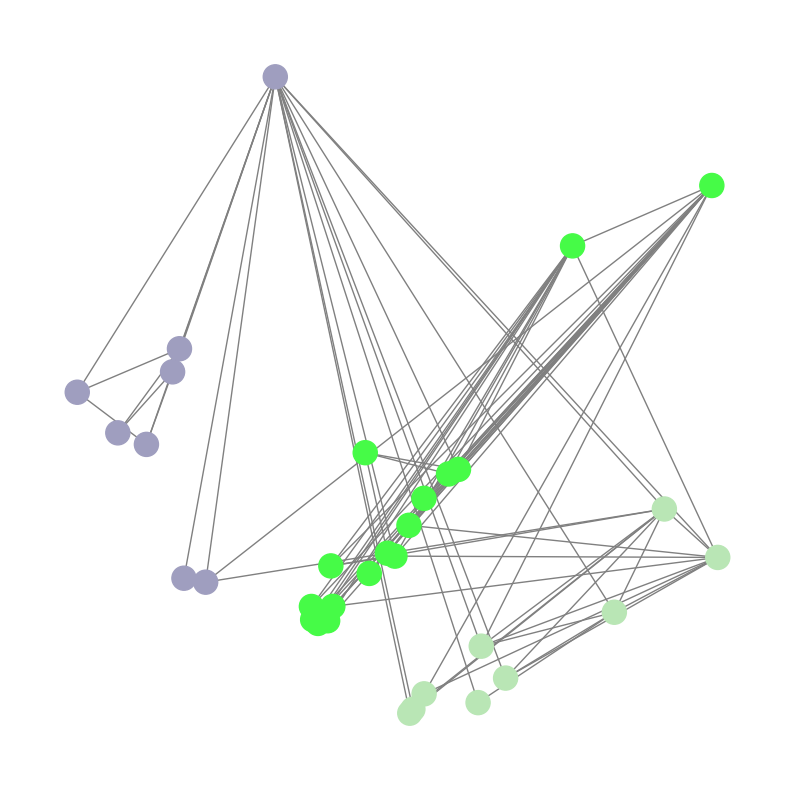

In [30]:
rep = model(indices, encode=True, embed=True)
embed_dict = {i: rep[:,i] for i in range(rep.shape[1])}
draw_encoding(G, embed_dict, node_color, name=f'Encoded embedding')

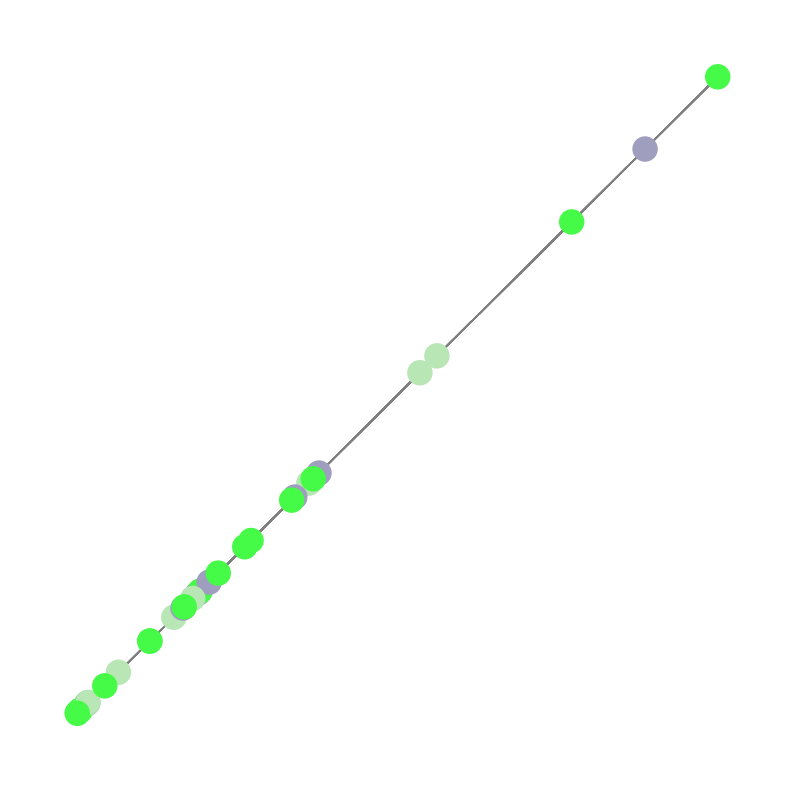

In [31]:
model.embedding.W = np.zeros(model.embedding.W.shape)
rep = model(indices, encode=True, embed=True)
embed_dict = {i: rep[:,i] for i in range(rep.shape[1])}
draw_encoding(G, embed_dict, node_color, name=f'Encoded embedding')

### Citation

```
@article{kipf2016semi,
  title={Semi-supervised classification with graph convolutional networks},
  author={Kipf, Thomas N and Welling, Max},
  journal={arXiv preprint arXiv:1609.02907},
  year={2016}
}
```

### References
1. [QUESTION about GCN's back propagation? #4021](https://github.com/dmlc/dgl/issues/4021)
2. [Graph Convolutional Networks in NumPy](https://github.com/zjost/blog_code/blob/master/gcn_numpy/gcn_from_scratch.ipynb)
3. [Backpropagation in an embedding layer](https://medium.com/@ilyarudyak/back-propagation-in-an-embedding-layer-30382fa7f023)
4. [Classification and Loss Evaluation - Softmax and Cross Entropy Loss](https://deepnotes.io/softmax-crossentropy)
5. [CS294A Lecture notes - Sparse autoencoder by Andrew Ng](https://web.stanford.edu/class/cs294a/sparseAutoencoder_2011new.pdf)